# Vectorizing raster output with OpenCV and Shapely

## Dependencies

In [1]:
# Install Dependencies

# We need libgeos-dev for shapely
!apt-get install -y libgeos-dev libsm6 libxext6
# Install numpy, shapely and opencv
!pip install numpy shapely[vectorized] scikit-image geojson matplotlib opencv-python

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


## Data Loading & Visualisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import cv2

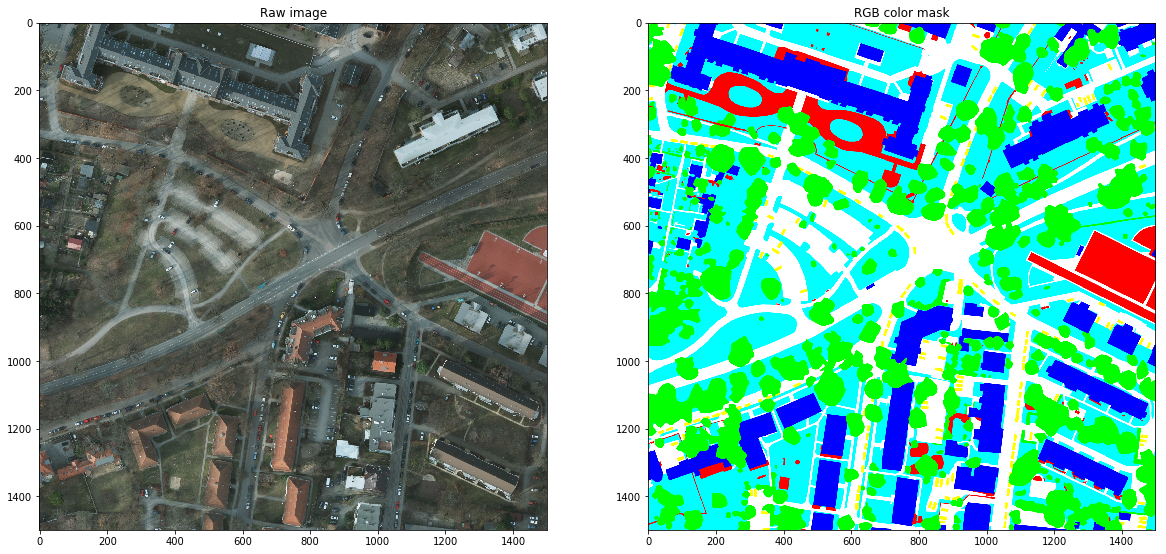

In [3]:
# Let's imagine we have a two class output (sigmoid)
PATH_TO_IMAGE = "https://storage.googleapis.com/theplayground-ml_public/example_image.png"
PATH_TO_LABEL = "https://storage.googleapis.com/theplayground-ml_public/example_label.png"

# Reading images
img = Image.open(BytesIO(requests.get(PATH_TO_IMAGE).content))
img = np.asarray(img)
msk = Image.open(BytesIO(requests.get(PATH_TO_LABEL).content))
msk = np.asarray(msk)

# Plotting images side by side
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.gca().set_title('Raw image')
plt.subplot(122)
plt.gca().set_title('RGB color mask')
plt.imshow(msk)
plt.show()

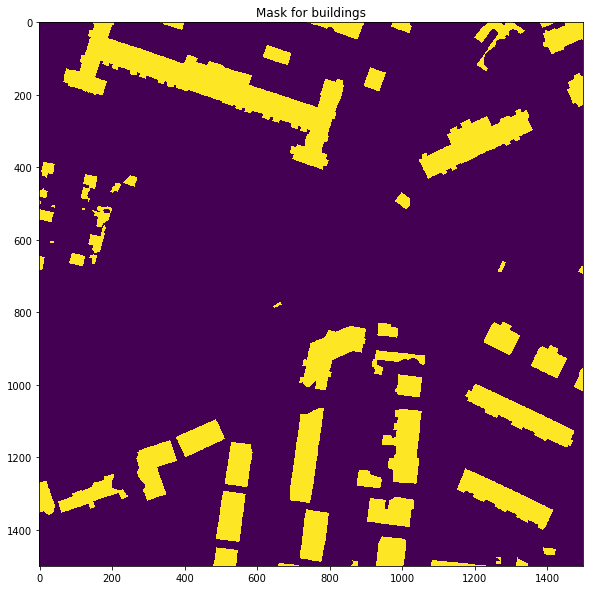

In [4]:
# The potsdam dataset class dict
class_dict = dict(building=(0, 0, 255),
low_vegetation= (0, 255, 255),
tree=(0, 255, 0),
car=(255, 255, 0),
clutter=(255, 0, 0))

# Let's select the building class
target_label = class_dict['building']
msk_class = np.all(msk[:,:,:3]==np.asarray(target_label),axis=-1)
plt.figure(figsize=(10,10))
plt.gca().set_title('Mask for buildings')
plt.imshow(msk_class)
plt.show()

## Class Raster Vectorization

In [5]:
# Imports

import skimage.measure
import shapely.geometry
import shapely.ops
import geojson
import time

### Polygons functions

In [6]:
def polygonize_contours_skimage(raster):
    """
    From a binary raster, vectorize contours using scikit-image marching square algorithm
    Args:
        raster: numpy ndarray

    Returns:
        list of shapely.geometry.Polygon
    """
    contours = skimage.measure.find_contours(raster, 0.5)
    polygons = []
    if len(contours) > 0:
        for cnt in contours:
            # We need
            cnt[:, [0, 1]] = cnt[:, [1, 0]]
            n, k = cnt.shape
            if n > 2:
                polygon = shapely.geometry.Polygon(cnt)
                polygons.append(polygon)
    return polygons


def polygonize_contours_opencv(raster):
    """
    From a binary raster, vectorize contours using opencv find_contours
    Args:
        raster: numpy ndarray

    Returns:
        list of shapely.geometry.Polygon
    """
    raster = raster.astype(np.float32)
    raster *= 255.
    raster = np.clip(raster, 0., 255.)
    raster = raster.astype(np.uint8)
    _, contours, _ = cv2.findContours(raster, cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for cnt in contours:
        n, h, k = cnt.shape
        if n > 2:
            cnt = cnt.reshape(n, k)
            hull_polygon = shapely.geometry.Polygon(cnt)
            polygons.append(hull_polygon)

    return polygons


def check_valid_polygons(polygons):
    """
    Returns a list of polygons that are invalid from a list of polygons
    Args:
        polygons: list of polygons

    Returns:
        list of polygons that are invalid
    """
    invalid_polygons = []
    for p in polygons:
        if not p.is_valid:
            invalid_polygons.append(p)
    return invalid_polygons


def sanitize_polygons(polygons, min_size=0.):
    """
    Apply buffer(0) and filter out small and invalid polygons
    Return a new list (the old one is emptied)
    Args:
        polygons:  list of shapely.geometry.Polygon
        min_size: Min size to filter polygons

    Returns:
        list of shapely.geometry.Polygon

    """
    valid_polygons = []

    while len(polygons) > 0:
        pol = polygons.pop(0)
        pol = pol.buffer(0)
        if pol.is_valid:
            if pol.geom_type == 'MultiPolygon':
                for subpol in pol:
                    polygons.append(subpol)
            elif pol.geom_type == 'Polygon':
                if pol.is_valid and pol.area > min_size:
                    valid_polygons.append(pol)
    return valid_polygons


def union_polygons(polygons):
    """
    Apply unary union to list of polygons to avoid overlapping polygons
    Original list is untouched
    Args:
        polygons: list of polygons

    Returns:
        list of polygons
    """
    if len(polygons) == 0:
        return []
    else:
        polygons = shapely.ops.unary_union(polygons)
        if polygons.geom_type == "Polygon":
            polygons = [polygons]
        else:
            polygons = [polygon for polygon in polygons]
        return polygons


def transform_polygons(polygons, polygon_mode):
    """
    Transform polygon to their desired shape
    Original list is untouched
    Args:
        polygons: list of shapely polygons
        polygon_mode: "","convex_hull","rotated_rectangle", "bbox"

    Returns:
        list of transformed shapely;geometry.polygons
    """
    transformed_polygons = []

    for polygon in polygons:
        if polygon_mode == "convex_hull":
            polygon = polygon.convex_hull
        elif polygon_mode == "rotated_rectangle":
            polygon = polygon.minimum_rotated_rectangle
        elif polygon_mode == "bbox":
            polygon = polygon.envelope
        if polygon.is_valid:
            transformed_polygons.append(polygon)

    return transformed_polygons

In [7]:
def plot_polygons(polygons, color=(0, 0, 255), im_size=None,title=None):
    """
    Plot polygons using matplotlib
    Args:
        polygons: 
        color: 
        im_size: 

    Returns:

    """
    plt.figure(figsize=(10, 10))
    color = [float(c) / 255. for c in color]
    for polygon in polygons:
        x, y = polygon.exterior.xy
        plt.plot(x, y, color=color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    if im_size is None:
        plt.ylim(max(plt.ylim()), min(plt.ylim()))
    else:
        h, w = im_size[:2]
        plt.xlim(0, w)
        plt.ylim(h, 0)
    if title is not None:
        plt.gca().set_title(str(title))
    plt.show()

### Vectorizing a raster

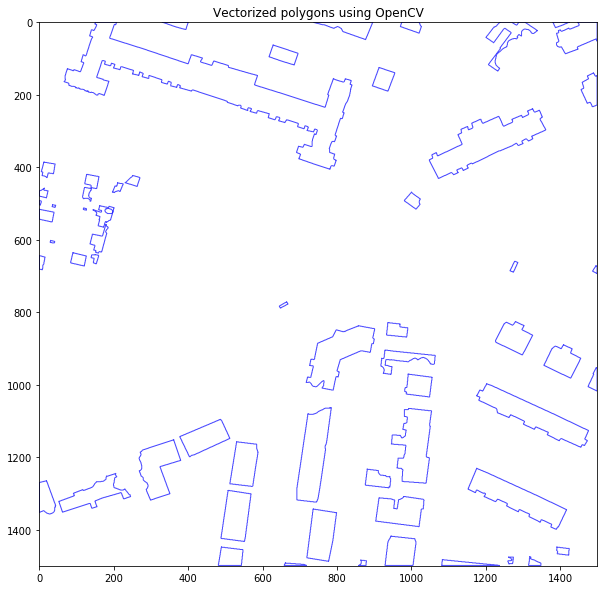

0.315008878708


In [8]:
t = time.time()
polygons = polygonize_contours_opencv(msk_class)
plot_polygons(polygons, im_size=msk.shape,title="Vectorized polygons using OpenCV")
print(time.time()-t)

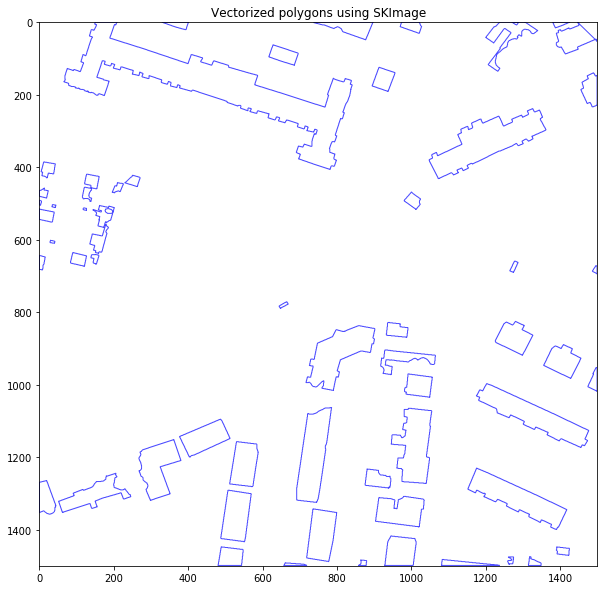

0.417418003082


In [9]:
t = time.time()
skimage_polygons = polygonize_contours_skimage(msk_class)
plot_polygons(skimage_polygons, im_size=msk.shape,title="Vectorized polygons using SKImage")
print(time.time()-t)

OpenCV vectorization seems better and faster (however it produces more "invalid" polygons and requires C++ dependencies)

### Correcting invalid polygons using buffer

There are 7 invalid polygons


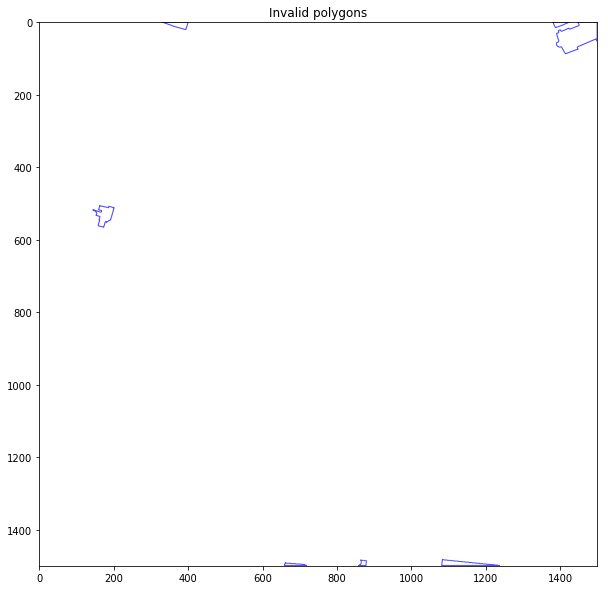

In [10]:
invalid_polygons = check_valid_polygons(polygons)
print("There are %d invalid polygons" % len(invalid_polygons))
plot_polygons(invalid_polygons, im_size=msk.shape, title="Invalid polygons")

59


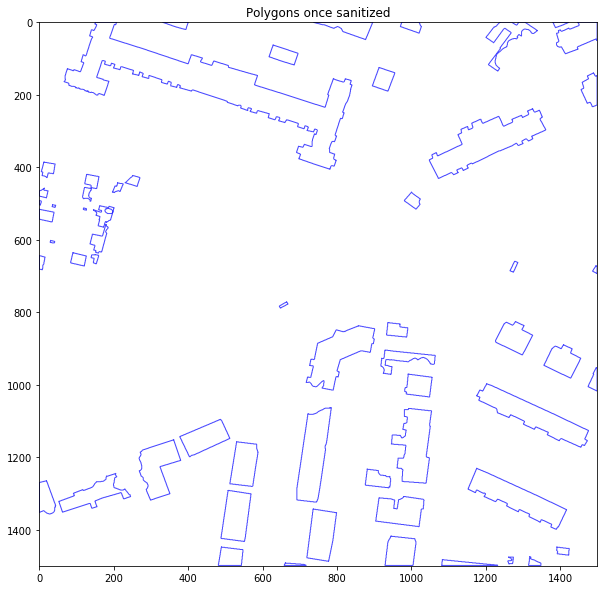

In [11]:
polygons = sanitize_polygons(polygons)
print(len(polygons))
plot_polygons(polygons,im_size=msk.shape, title = "Polygons once sanitized")

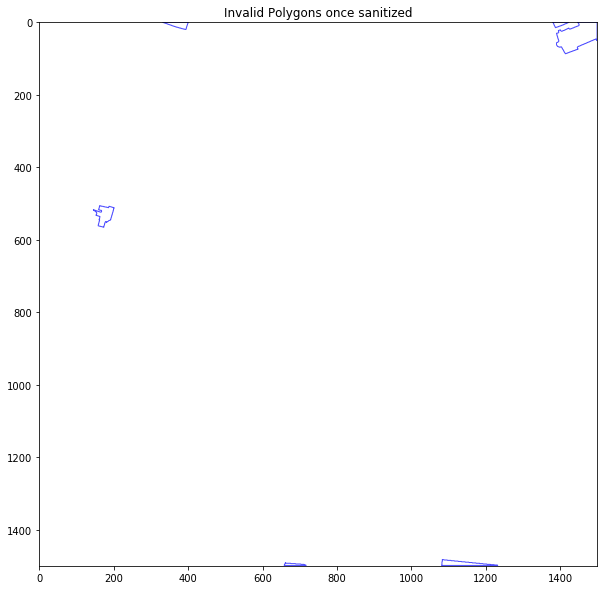

In [12]:
invalid_polygons = sanitize_polygons(invalid_polygons)
plot_polygons(invalid_polygons,im_size=msk.shape, title = "Invalid Polygons once sanitized")

### Avoiding overlapping polygons using unary_union

59
58


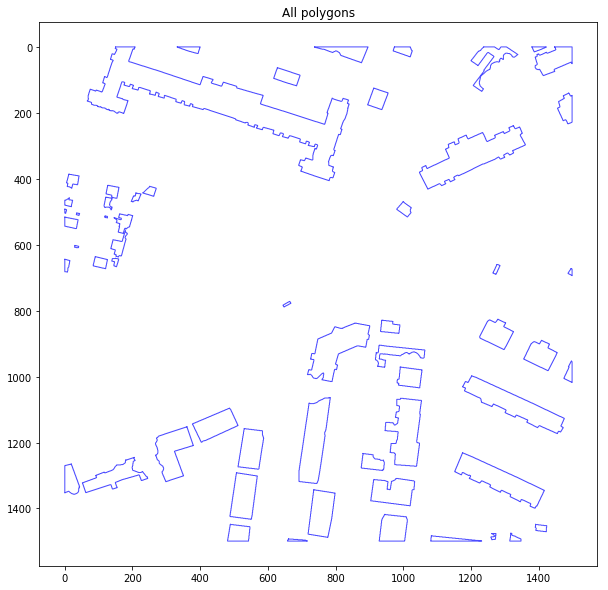

In [13]:
print(len(polygons))
polygons = sanitize_polygons(union_polygons(polygons))
print(len(polygons))
plot_polygons(polygons, title="All polygons")

### Transforming polygons

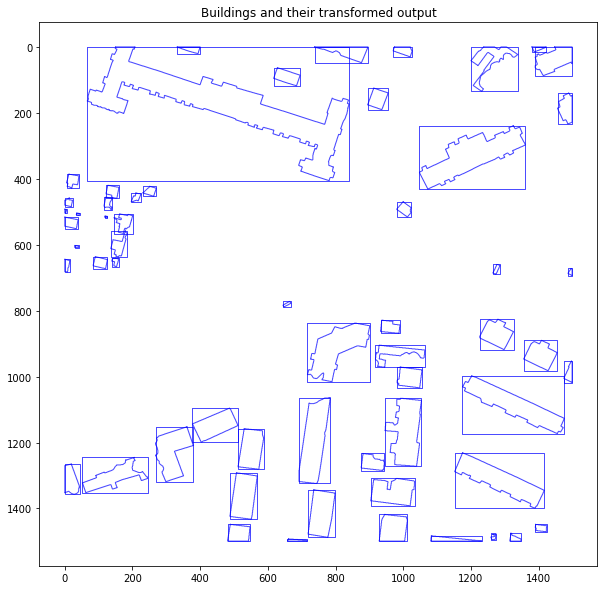

In [14]:
transformed_polygons = transform_polygons(polygons,"bbox")
plot_polygons(polygons+sanitize_polygons(transformed_polygons),title="Buildings and their transformed output")

### Converting polygons to geojson FeatureCollection format

More info:https://macwright.org/2015/03/23/geojson-second-bite

In [15]:
def to_geojson(polygons,label=""):
    features = []
    for p in polygons:
        features.append(geojson.Feature(geometry=shapely.geometry.mapping(p),properties={"category":label}))
    return features

In [16]:
features = to_geojson(polygons)

In [17]:
feature_collection = geojson.FeatureCollection(features)

## Full Example raster to geojson

In [18]:
im_size = msk.shape
msk_for_polygons = np.zeros(im_size[:2] + (3,), dtype=np.uint8)
all_polygons = []
features = []
for label in class_dict:
    print(label)
    msk_class = np.all(msk[:,:,:3]==np.asarray(class_dict[label]),axis=-1)
    polygons = polygonize_contours_opencv(msk_class)
    polygons = sanitize_polygons(polygons)
    all_polygons += [(p,class_dict[label]) for p in polygons]
    features += to_geojson(polygons,label=label)
feature_collection = geojson.FeatureCollection(features)

building
car
low_vegetation
clutter
tree


In [19]:
def polygon_and_colors(polygons_and_colors, im_size=None,title=None):
    """
    Plot polygons using matplotlib
    Args:
        polygons: 
        color: 
        im_size: 

    Returns:

    """
    plt.figure(figsize=(10, 10))
    for polygon,color in polygons_and_colors:
        color = [float(c) / 255. for c in color]
        x, y = polygon.exterior.xy
        plt.plot(x, y, color=color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    if im_size is None:
        plt.ylim(max(plt.ylim()), min(plt.ylim()))
    else:
        h, w = im_size[:2]
        plt.xlim(0, w)
        plt.ylim(h, 0)
    if title is not None:
        plt.gca().set_title(str(title))
    plt.show()

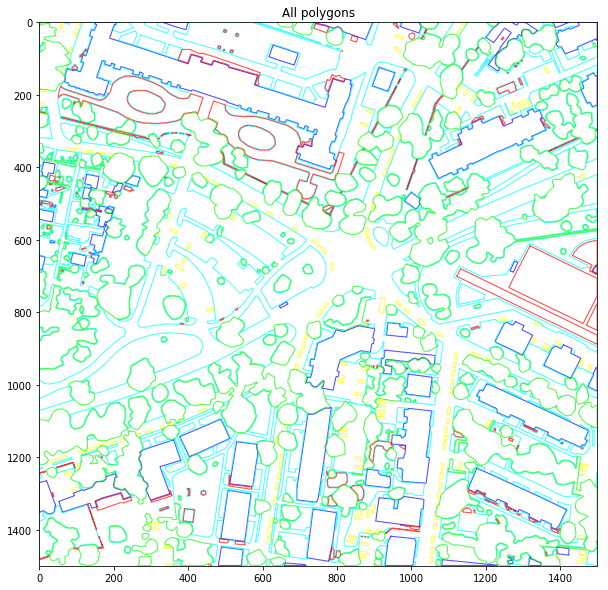

In [20]:
polygon_and_colors(all_polygons,im_size=msk.shape,title="All polygons")